# ActBlue analysis

In [1]:
import json
import math
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import psycopg2
import requests
import gender_guesser.detector as gender

In [2]:
%matplotlib inline

plt.style.use('ggplot')

pd.options.display.float_format = '{:,.2f}'.format

In [3]:
def read_or_save(name, func):
    path = 'pickles/' + name + '.pickle.gz'
    if (os.path.isfile(path)):
        return pd.read_pickle(path)
    else:
        result = func()
        os.makedirs('pickles', exist_ok=True)
        result.to_pickle(path)
        return result

In [4]:
committee_id = "C00401224"
year_since = 2013

In [5]:
with open("config.json") as f:
    conf = json.load(f)
conn = psycopg2.connect(
    dbname=conf['dbname'],
    user=conf['user'],
    host=conf['host'],
    password=conf['password']
)
conn.autocommit = True

### How many reports are in the database?
Jan. 1, 2013 — now

In [6]:
filings_count = read_or_save(
    'filings_count',
    lambda: pd.read_sql("""
    SELECT count(*)
    FROM
      (SELECT filing_id
       FROM fec_filings
       UNION SELECT filing_id
       FROM fec_paper_filings) AS filings;
    """, con=conn)
)
filings_count

,count
0,431230


### Are there other committees itemizing a large number of transfers?
Jan. 1, 2017 — now

In [7]:
transfer_committees = read_or_save(
    'transfer_committees',
    lambda: pd.read_sql("""
    SELECT filer_committee_id_number,
           fec_committees.name,
           count,
           sum
    FROM
        (SELECT filer_committee_id_number,
               count(*) AS count,
               sum(expenditure_amount) as sum
        FROM fec_expenditures
        JOIN fec_amended_filings using (filing_id)
        WHERE 
        -- filer_committee_id_number != '""" + committee_id + """' AND 
         extract(YEAR
                      FROM expenditure_date) >= 2017
          -- AND beneficiary_committee_fec_id IS NOT NULL
          AND form_type = 'SB23'
        GROUP BY filer_committee_id_number
        ORDER BY COUNT DESC
        LIMIT 10) as counts
    LEFT JOIN fec_committees
    ON fec_committees.id = filer_committee_id_number
    """, con=conn)
)

transfer_committees

,filer_committee_id_number,name,count,sum
0,C00401224,ACTBLUE,30462320,"919,575,587.04"
1,C00632133,SWING LEFT,1675478,"4,815,571.82"
2,C00193433,EMILY'S LIST,118998,"10,114,018.79"
3,C00341396,MOVEON.ORG POLITICAL ACTION,76279,"2,771,545.04"
4,C00448696,SENATE CONSERVATIVES FUND,62895,"6,828,088.98"
5,C00552851,HOUSE FREEDOM FUND,23366,"5,315,812.00"
6,C00468314,"DEMOCRACY ENGINE, INC., PAC",20138,"5,347,428.25"
7,C00252940,LEAGUE OF CONSERVATION VOTERS ACTION FUND,16429,"3,175,549.50"
8,C00432260,CLUB FOR GROWTH PAC,16056,"4,449,005.99"
9,C00608489,GREAT AMERICA PAC,11818,"135,157.26"


### How much was raised from unitemized contributions versus itemized for the 2018 and 2014 cycles by congressional candidates of each party?

#### 2014
Jan. 1, 2013 — September 30, 2014

In [8]:
def calc_candidate_unitemized_by_party(cycle):
     return read_or_save(
            'candidate_unitemized_by_party_' + str(cycle)[2:],
            lambda: pd.read_sql("""
            SELECT CASE
                       WHEN cand_pty_affiliation = 'DEM' THEN 'Democrat'
                       WHEN cand_pty_affiliation = 'DFL' THEN 'Democrat'
                       WHEN cand_pty_affiliation = 'REP' THEN 'Republican'
                       ELSE 'third party'
                   END AS party,
                   -- cand_office,
                   count(DISTINCT cand_id) as candidates,
                   sum(col_a_individual_contributions_itemized) AS itemized,
                   sum(col_a_individual_contributions_unitemized) AS unitemized,
                   sum(col_a_total_individual_contributions) AS indivs
            FROM
              (SELECT DISTINCT ON (cand_pcc) *
               FROM fec_candidates
               WHERE
               cand_election_yr IN ('%(year_before)s','%(cycle)s') AND
             cand_pcc IS NOT NULL
               ORDER BY cand_pcc) AS cands
            JOIN
              (SELECT filing_id,
                      filer_committee_id_number,
                      col_a_individual_contributions_itemized,
                  col_a_individual_contributions_unitemized,
                  col_a_total_individual_contributions,
                  col_a_total_receipts,
                  col_a_total_disbursements,
                  coverage_from_date,
                  coverage_through_date
           FROM fec_campaign_summaries
           JOIN fec_amended_filings USING (filing_id)
           WHERE filing_id >= 2000
           UNION SELECT DISTINCT ON (filer_committee_id_number,
                                     coverage_from_date,
                                     coverage_through_date) filing_id,
                                    filer_committee_id_number,
                                    col_a_individual_contributions_itemized,
                                    col_a_individual_contributions_unitemized,
                                    col_a_total_individual_contributions,
                                    col_a_total_receipts,
                                    col_a_total_disbursements,
                                    coverage_from_date,
                                    coverage_through_date
           FROM fec_paper_campaign_summaries
           WHERE col_a_total_individual_contributions IS NOT NULL
           ORDER BY filer_committee_id_number,
                    coverage_through_date,
                    coverage_from_date,
                    filing_id DESC) AS summaries ON cand_pcc = filer_committee_id_number
        WHERE extract(YEAR
                      FROM coverage_through_date) >= %(year_before)s
          AND coverage_through_date <= '%(cycle)s-09-30'::date
          -- AND (col_a_total_receipts > 0
        --       OR col_a_total_disbursements > 0)
        GROUP BY -- cand_office,
                 party
        ORDER BY indivs DESC
        """, con=conn, params={"cycle":cycle,"year_before":cycle-1})
    )
    
candidate_unitemized_by_party_14 = calc_candidate_unitemized_by_party(2014)

candidate_unitemized_by_party_14

,party,candidates,itemized,unitemized,indivs
0,Republican,879,"386,281,126.61","68,550,509.73","454,992,766.26"
1,Democrat,669,"340,445,390.26","81,131,227.89","421,581,550.15"
2,third party,102,"3,029,102.42","845,118.46","3,878,881.96"


#### 2018
Jan. 1, 2017 — Setptember 30, 2018

In [9]:
candidate_unitemized_by_party_18 = calc_candidate_unitemized_by_party(2018)

candidate_unitemized_by_party_18

,party,candidates,itemized,unitemized,indivs
0,Democrat,1301,"696,628,106.39","276,459,424.00","975,209,976.14"
1,Republican,952,"381,896,924.92","86,759,611.53","469,009,808.45"
2,third party,155,"10,106,223.08","8,605,058.75","18,765,006.83"


### Which ActBlue reports do we have?
Jan 1, 2013 — now

In [10]:
actblue_summaries = read_or_save(
    'actblue_summaries',
    lambda: pd.read_sql("""
    SELECT *
    FROM fec_pac_summaries
    JOIN fec_amended_filings USING (filing_id)
    WHERE filer_committee_id_number = '""" + committee_id + """'
    AND extract(year from coverage_through_date) >= """ + str(year_since) + """
    ORDER BY coverage_through_date DESC;
    """, con=conn, parse_dates={
        'coverage_from_date': '%Y-%m-%d',
        'coverage_through_date': '%Y-%m-%d'
    })
)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(actblue_summaries[[
        'filing_id',
        'coverage_from_date',
        'coverage_through_date',
        'report_code',
        'col_a_total_contributions'
    ]])

,filing_id,coverage_from_date,coverage_through_date,report_code,col_a_total_contributions
0,1277598,2018-09-01,2018-09-30,M10,"144,336,242.30"
1,1263179,2018-08-01,2018-08-31,M9,"88,719,194.67"
2,1258193,2018-07-01,2018-07-31,M8,"60,945,546.97"
3,1251343,2018-06-01,2018-06-30,M7,"63,088,119.19"
4,1240253,2018-05-01,2018-05-31,M6,"43,130,233.11"
5,1233520,2018-04-01,2018-04-30,M5,"38,328,646.45"
6,1225971,2018-03-01,2018-03-31,M4,"57,825,086.02"
7,1215697,2018-02-01,2018-02-28,M3,"41,932,847.30"
8,1224404,2018-01-01,2018-01-31,M2,"32,937,704.67"
9,1224416,2017-12-01,2017-12-31,YE,"51,181,861.72"


### Are there any reports that FEC.gov has that we don't or vice versa?
Jan. 1, 2013 — now

In [11]:
def get_reports(committee_id):
    base = "https://api.open.fec.gov/v1/"
    url = base + "committee/" + committee_id + "/reports/?api_key=" + conf['fec_key'] + "&is_amended=False&per_page=100"

    return pd.DataFrame(requests.get(url).json()['results'])

actblue_api_summaries = read_or_save('actblue_api_summaries', lambda: get_reports(committee_id))
pd.to_numeric(actblue_api_summaries['calendar_ytd'])
actblue_api_summaries = actblue_api_summaries[actblue_api_summaries['calendar_ytd'] >= year_since]
actblue_api_summaries[['file_number','calendar_ytd']]

pd.DataFrame(pd.concat([actblue_api_summaries['file_number'],
                        actblue_summaries['filing_id']]).drop_duplicates(keep=False))

,0
0,1277598


### How many itemized federal individual contributions from ActBlue are we analyzing?
Jan. 1, 2013 — now

In [12]:
def cycle(year):
    return math.ceil(float(year) / 2.) * 2

assert (cycle(2013) == 2014 and
    cycle(2014) == 2014 and
    cycle(2015) == 2016 and
    cycle(2016) == 2016 and
    cycle(2017) == 2018 and
    cycle(2018) == 2018),"unexpected cycle output"

In [13]:
actblue_contrib_count_by_year = read_or_save(
    'actblue_contrib_count_by_year',
    lambda: pd.read_sql("""
    -- DROP MATERIALIZED VIEW actblue_contribs;

    CREATE MATERIALIZED VIEW IF NOT EXISTS actblue_contribs AS
    SELECT contribs.*,
           fec_expenditures.election_code,
           beneficiary_committee_fec_id,
           beneficiary_candidate_fec_id,
           beneficiary_candidate_state,
           beneficiary_candidate_office,
           coalesce(cands.cand_id,cand_comms.cand_id) AS cand_id,
           coalesce(cands.cand_pty_affiliation,cand_comms.cand_pty_affiliation) AS cand_pty_affiliation,
           coalesce(cands.cand_office_st,cand_comms.cand_office_st) AS cand_office_st,
           coalesce(cands.cand_office,cand_comms.cand_office) AS cand_office,
           coalesce(cands.cand_pcc,cand_comms.cand_pcc) AS cand_pcc
    FROM
      (SELECT fec_contributions.filing_id,
              transaction_id,
              contributor_last_name,
              contributor_first_name,
              contributor_street_1,
              contributor_city,
              contributor_state,
              contributor_zip_code,
              contribution_date,
              contribution_amount,
              contributor_employer,
              contributor_occupation,
              memo_text_description
       FROM fec_contributions
       WHERE filing_id IN
           (SELECT filing_id
            FROM fec_pac_summaries
            JOIN fec_amended_filings USING (filing_id)
            WHERE filer_committee_id_number = 'C00401224'
              AND extract(YEAR
                          FROM coverage_through_date) >= 2013
            ORDER BY coverage_through_date DESC)
         AND form_type = 'SA11AI') AS contribs
    LEFT JOIN fec_expenditures ON fec_expenditures.filing_id IN
      (SELECT filing_id
       FROM fec_pac_summaries
       JOIN fec_amended_filings USING (filing_id)
       WHERE filer_committee_id_number = 'C00401224'
         AND extract(YEAR
                     FROM coverage_through_date) >= 2013
       ORDER BY coverage_through_date DESC)
    AND fec_expenditures.form_type = 'SB23'
    AND 'SB23_' || replace(transaction_id,'SA11AI_','') = transaction_id_number
    LEFT JOIN
      (SELECT DISTINCT ON (cand_id) cand_id,
                          cand_pcc,
                          cand_pty_affiliation,
                          cand_office_st,
                          cand_office
       FROM fec_candidates
       ORDER BY cand_id,
                cand_election_yr::int DESC) AS cands ON cands.cand_id = beneficiary_candidate_fec_id
    LEFT JOIN
      (SELECT DISTINCT ON (cand_pcc) cand_id,
                          cand_pcc,
                          cand_pty_affiliation,
                          cand_office_st,
                          cand_office
       FROM fec_candidates
       ORDER BY cand_pcc,
                cand_election_yr::int DESC) AS cand_comms
    ON cand_comms.cand_pcc = beneficiary_committee_fec_id;
                
    -- CREATE INDEX ON actblue_contribs ()

    GRANT ALL ON TABLE actblue_contribs TO redash_default;
    GRANT ALL ON TABLE actblue_contribs TO politics;

    -- REFRESH MATERIALIZED VIEW actblue_contribs;
    -- ANALYZE actblue_contribs;

    SELECT extract(YEAR
                   FROM contribution_date) AS YEAR,
           count(*),
           sum(contribution_amount)
    FROM actblue_contribs
    GROUP BY extract(YEAR
                     FROM contribution_date);
    """, con=conn)
)

actblue_contrib_count_by_year['cycle'] = actblue_contrib_count_by_year[~actblue_contrib_count_by_year['year'].isna()]['year'].apply(cycle)

actblue_contrib_count_by_cycle = pd.DataFrame(
    actblue_contrib_count_by_year.groupby(actblue_contrib_count_by_year['cycle'])['count','sum'].sum()
)
actblue_contrib_count_by_cycle

,count,sum
cycle,,
"2,014.00",11833542,"276,701,162.20"
"2,016.00",30578103,"679,907,198.18"
"2,018.00",37861126,"955,078,929.41"


### How much in itemized federal individual contributions to Congress are we analyzing?
Jan. 1, 2013 — now

In [14]:
actblue_congress_contrib_count_by_year = read_or_save(
    'actblue_congress_contrib_totals',
    lambda: pd.read_sql("""
    SELECT extract(YEAR
                   FROM contribution_date) AS YEAR,
           count(*),
           sum(contribution_amount)
    FROM actblue_contribs
    WHERE beneficiary_candidate_office IN ('H','S')
    GROUP BY extract(YEAR
                     FROM contribution_date);
    """, con=conn)
)

actblue_congress_contrib_count_by_year['cycle'] = actblue_congress_contrib_count_by_year[~actblue_congress_contrib_count_by_year['year'].isna()]['year'].apply(cycle)

actblue_congress_contrib_count_by_cycle = pd.DataFrame(
    actblue_congress_contrib_count_by_year.groupby(actblue_congress_contrib_count_by_year['cycle'])['count','sum'].sum()
)
actblue_congress_contrib_count_by_cycle


,count,sum
cycle,,
"2,014.00",3356935,"113,654,006.95"
"2,016.00",6680808,"219,494,286.50"
"2,018.00",15033855,"545,955,211.40"


In [15]:
actblue_congress_contrib_count_by_cycle.to_csv('data/actblue_contribs_by_cycle.csv')

### How have total contributions to ActBlue changed over reporting periods?
Jan. 1, 2013 — now

Text(0.5,1,'Total contributions by reporting period')

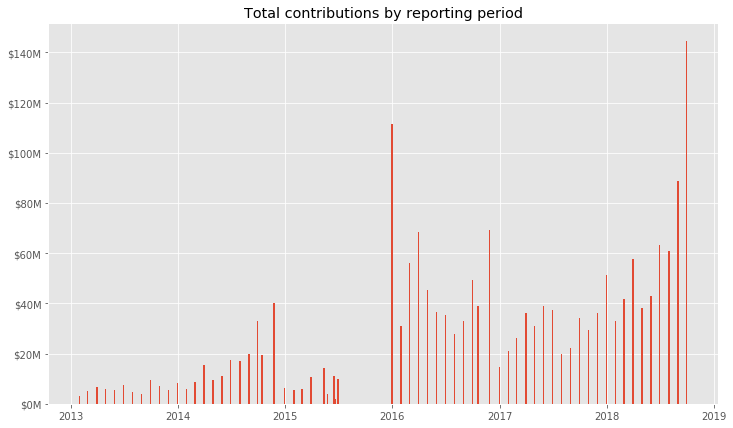

In [16]:
contribs_over_time = actblue_summaries[['coverage_through_date','col_a_total_contributions']]

# https://scentellegher.github.io/programming/2017/05/24/pandas-bar-plot-with-formatted-dates.html
contribs_over_time.set_index('coverage_through_date',inplace=True)

fig, ax = plt.subplots(figsize=(12,7))

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# https://matplotlib.org/examples/pylab_examples/custom_ticker1.html
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: '$%1.fM' % (x*1e-6)))

ax.bar(contribs_over_time.index, contribs_over_time['col_a_total_contributions'], width=5)

ax.set_title('Total contributions by reporting period')

### Contributions by day

In [17]:
actblue_contribs_by_day = read_or_save(
    'actblue_contribs_by_day',
    lambda: pd.read_sql("""
    SELECT contribution_date,
           sum(contribution_amount),
           count(*)
    FROM actblue_contribs
    -- where extract(year from contribution_date) >= 2017 and
    -- where cand_office in ('S','H')
    GROUP BY contribution_date
    """, con=conn)
)

actblue_contribs_by_day

,contribution_date,sum,count
0,2013-01-01,"35,189.95",1749
1,2013-01-02,"20,131.95",991
2,2013-01-03,"69,351.58",4358
3,2013-01-04,"34,018.57",1400
4,2013-01-05,"17,418.41",666
5,2013-01-06,"12,100.46",642
6,2013-01-07,"40,888.69",1919
7,2013-01-08,"39,004.71",2779
8,2013-01-09,"48,775.86",1412
9,2013-01-10,"73,739.31",4289


In [18]:
actblue_contribs_by_day.to_csv('data/actblue_contribs_by_day.csv')

Spreadsheet: [actblue_contribs_by_day.csv](data/actblue_contribs_by_day.csv)

### Congressional contributions by day

In [19]:
actblue_congress_contribs_by_day = read_or_save(
    'actblue_congress_contribs_by_day',
    lambda: pd.read_sql("""
    SELECT contribution_date,
           sum(contribution_amount),
           count(*)
    FROM actblue_contribs
    -- where extract(year from contribution_date) >= 2017 and
    where cand_office in ('S','H')
    GROUP BY contribution_date
    """, con=conn)
)

actblue_congress_contribs_by_day

,contribution_date,sum,count
0,2013-01-01,"9,878.94",167
1,2013-01-02,"8,158.56",304
2,2013-01-03,"5,105.80",201
3,2013-01-04,"5,070.50",159
4,2013-01-05,"5,453.94",140
5,2013-01-06,"1,922.65",75
6,2013-01-07,"3,934.05",50
7,2013-01-08,"8,805.86",176
8,2013-01-09,"29,203.31",354
9,2013-01-10,"10,161.63",335


In [20]:
actblue_congress_contribs_by_day.to_csv('data/actblue_congress_contribs_by_day.csv')

Spreadsheet: [actblue_congress_contribs_by_day.csv](data/actblue_congress_contribs_by_day.csv)

### How have total federal contributions to ActBlue changed between cycles?
Jan. 1, 2013 — now

In [21]:
actblue_summaries['cycle'] = actblue_summaries.coverage_through_date.dt.year.apply(cycle)

contribs_by_cycle = pd.DataFrame(
    actblue_summaries.groupby(actblue_summaries['cycle'])['col_a_total_contributions'].sum()
)
contribs_by_cycle

,col_a_total_contributions
cycle,
2014,"276,701,106.20"
2016,"679,908,044.18"
2018,"955,072,819.41"


#### Cycle to date

In [22]:
actblue_summaries['cycle'] = actblue_summaries.coverage_through_date.dt.year.apply(cycle)

actblue_summaries_to_date = actblue_summaries[((actblue_summaries['coverage_through_date'] >= '2017-01-01') &
                                              (actblue_summaries['coverage_through_date'] <= '2018-08-31')) |
                                              ((actblue_summaries['coverage_through_date'] >= '2015-01-01') &
                                              (actblue_summaries['coverage_through_date'] <= '2016-08-31')) | 
                                              ((actblue_summaries['coverage_through_date'] >= '2013-01-01') &
                                              (actblue_summaries['coverage_through_date'] <= '2014-08-31'))]

contribs_by_cycle = pd.DataFrame(
    actblue_summaries_to_date.groupby(actblue_summaries_to_date['cycle'])['col_a_total_contributions'].sum()
)
contribs_by_cycle

,col_a_total_contributions
cycle,
2014,"177,785,396.60"
2016,"507,793,452.61"
2018,"810,736,577.11"


Text(0.5,1,'Total contributions by cycle')

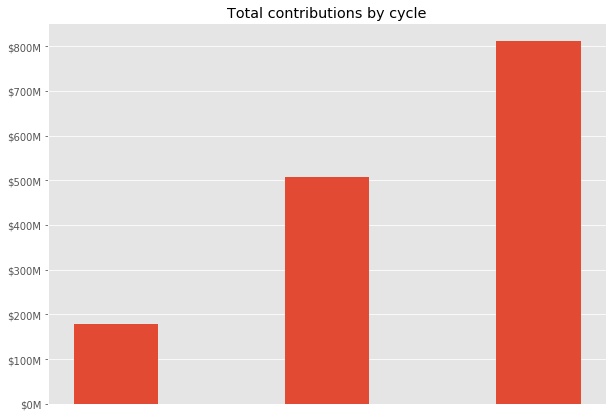

In [23]:
# https://scentellegher.github.io/programming/2017/05/24/pandas-bar-plot-with-formatted-dates.html
# contribs_by_year.set_index('coverage_through_date',inplace=True)

fig, ax = plt.subplots(figsize=(10,7))

ax.xaxis.set_major_locator(mdates.YearLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# https://matplotlib.org/examples/pylab_examples/custom_ticker1.html
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: '$%1.fM' % (x*1e-6)))

ax.bar(contribs_by_cycle.index, contribs_by_cycle['col_a_total_contributions'], width=0.8)

ax.set_title('Total contributions by cycle')

### Which committees receive contributions through ActBlue?
Jan. 1, 2013 — now

In [24]:
actblue_transfers = read_or_save(
    'actblue_transfers',
    lambda: pd.read_sql("""
    SELECT fec_committees.name,
           totals.*
    FROM
      (SELECT beneficiary_committee_fec_id,
              count(*),
              sum(contribution_amount)
       FROM actblue_contribs
       GROUP BY beneficiary_committee_fec_id) AS totals
    LEFT JOIN fec_committees ON beneficiary_committee_fec_id = fec_committees.id
    """, con=conn)
)
actblue_transfers.sort_values(by=['sum'], ascending=False).head(20)

,name,beneficiary_committee_fec_id,count,sum
0,DCCC,C00000935,11814400,"246,490,447.00"
1466,BERNIE 2016,C00577130,7674980,"198,901,495.65"
26,DSCC,C00042366,3486394,"98,566,985.16"
3693,None,None,16702739,"75,348,173.81"
1408,END CITIZENS UNITED,C00573261,3771328,"50,988,050.92"
670,BETO FOR TEXAS,C00501197,1150586,"45,538,960.43"
2089,JON OSSOFF FOR CONGRESS,C00630426,1430332,"27,468,759.69"
2475,DOUG JONES FOR SENATE COMMITTEE,C00640623,767342,"22,177,988.84"
1509,PROGRESSIVE TURNOUT PROJECT,C00580068,1499109,"20,580,459.30"
11,DNC SERVICES CORP./DEM. NAT'L COMMITTEE,C00010603,790624,"19,491,595.88"


### How much of this is a contribution to ActBlue?
Jan. 1, 2013 — now

In [25]:
actblue_itself = read_or_save(
    'actblue_itself',
    lambda: pd.read_sql("""
    SELECT count(*),
           sum(contribution_amount)
    FROM actblue_contribs
    WHERE memo_text_description = 'Contribution to ActBlue'
    """, con=conn)
)
actblue_itself

,count,sum
0,16478679,"48,182,124.56"


### How many Democratic campaigns received contributions through ActBlue? What percentage of Democratic campaigns is that?
Jan. 1, 2017 — now

In [26]:
actblue_proportion = read_or_save(
    'actblue_proportion',
    lambda: pd.read_sql("""
    SELECT actblue,
           count(*)
    FROM
      (SELECT cand_id,
              cand_pcc,
              CASE
                  WHEN COUNT IS NOT NULL THEN TRUE
                  ELSE FALSE
              END AS actblue
       FROM (SELECT DISTINCT ON (cand_id,
                               cand_pcc) *
           FROM fec_candidates
           WHERE cand_election_yr IN ('2018','2017')
             AND cand_pcc IS NOT NULL
             AND cand_pty_affiliation IN ('DFL',
                                      'DEM')
           ORDER BY cand_id,
                    cand_pcc) AS cands
       LEFT JOIN
         (SELECT fec_committees.name,
                 totals.*
          FROM
            (SELECT beneficiary_committee_fec_id,
                    count(*) AS COUNT,
                    sum(contribution_amount)
             FROM actblue_contribs
             WHERE extract(YEAR
                                FROM contribution_date) >= 2017
             GROUP BY beneficiary_committee_fec_id) AS totals
          LEFT JOIN fec_committees ON beneficiary_committee_fec_id = fec_committees.id) AS actblue_committees ON cand_pcc = beneficiary_committee_fec_id) AS actblue_candidates
    GROUP BY actblue
    """, con=conn)
)

actblue_proportion['percent'] = actblue_proportion['count']/actblue_proportion['count'].sum()*100

actblue_proportion

,actblue,count,percent
0,False,235,15.12
1,True,1319,84.88


### Rise of ActBlue: What percent of Democratic congresssional campaign cash from individuals was raised through ActBlue by cycle? How about 2014?

In [27]:
def calc_actblue_proportion_amount(cycle):
    return read_or_save(
        'actblue_proportion_amount_' + str(cycle)[2:],
        lambda: pd.read_sql('''
        WITH cands AS
          (SELECT DISTINCT ON (cand_pcc) *
           FROM fec_candidates
           WHERE cand_election_yr IN ('%(year_before)s',
                                      '%(cycle)s')
             AND cand_pty_affiliation IN ('DFL',
                                          'DEM')
             AND cand_pcc IS NOT NULL
           ORDER BY cand_pcc),
             candidate_totals AS
          (SELECT cand_id,
                  cand_pcc,
                  cand_name,
                  cand_office,
                  cand_office_st,
                  cand_office_district,
                  cand_election_yr,
                  coverage_from_date,
                  coverage_through_date,
                  col_a_total_individual_contributions
           FROM cands
           JOIN fec_campaign_summaries ON cand_pcc = filer_committee_id_number
           JOIN fec_amended_filings USING (filing_id)
           WHERE extract(YEAR
                         FROM coverage_through_date) >= %(year_before)s
             AND coverage_through_date <= '%(cycle)s-09-30'::date
             AND filing_id >= 2000
           UNION SELECT cand_id,
                        cand_pcc,
                        cand_name,
                        cand_office,
                        cand_office_st,
                        cand_office_district,
                        cand_election_yr,
                        coverage_from_date,
                        coverage_through_date,
                        col_a_total_individual_contributions
           FROM cands
           JOIN
             (SELECT DISTINCT ON (filer_committee_id_number,
                                  coverage_from_date,
                                  coverage_through_date) filing_id,
                                 filer_committee_id_number,
                                 col_a_total_individual_contributions,
                                 coverage_from_date,
                                 coverage_through_date
              FROM fec_paper_campaign_summaries
              WHERE col_a_total_individual_contributions IS NOT NULL
              ORDER BY filer_committee_id_number,
                       coverage_through_date,
                       coverage_from_date,
                       filing_id DESC) AS paper_totals ON cand_pcc = filer_committee_id_number
           WHERE extract(YEAR
                         FROM coverage_through_date) >= %(year_before)s
             AND coverage_through_date <= '%(cycle)s-09-30'::date)
        SELECT  cand_pcc,
                max(cand_name) as cand_name,
                max(cand_office) as cand_office,
                max(cand_office_st) as cand_office_st,
                max(cand_office_district) as cand_office_district,
                max(cand_election_yr) as cand_election_yr,
               array_agg(coverage_from_date) AS from_dates,
               array_agg(coverage_through_date) AS through_dates,
               sum(col_a_total_individual_contributions) AS committee_total,
               sum(actblue_total) AS actblue_total
        FROM
          (SELECT candidate_totals.cand_pcc,
                max(candidate_totals.cand_name) as cand_name,
                max(candidate_totals.cand_office) as cand_office,
                max(candidate_totals.cand_office_st) as cand_office_st,
                max(candidate_totals.cand_office_district) as cand_office_district,
                max(candidate_totals.cand_election_yr) as cand_election_yr,
                  coverage_from_date,
                  coverage_through_date,
                  col_a_total_individual_contributions,
                  sum(contribution_amount) AS actblue_total,
                  count(*) as actblue_count
           FROM candidate_totals
           LEFT JOIN actblue_contribs ON extract(YEAR
                                                 FROM coverage_through_date) >= %(year_before)s
           AND coverage_through_date <= '%(cycle)s-09-30'::date
           AND actblue_contribs.cand_pcc = candidate_totals.cand_pcc
           AND coverage_from_date <= contribution_date
           AND coverage_through_date >= contribution_date
           GROUP BY candidate_totals.cand_pcc,
                    col_a_total_individual_contributions,
                    coverage_from_date,
                    coverage_through_date) AS totals
        GROUP BY cand_pcc
        ''',con=conn,params={"cycle":cycle,"year_before":cycle-1})
    )

actblue_proportion_amount = calc_actblue_proportion_amount(2018)

In [28]:
actblue_proportion_amount['percent'] = actblue_proportion_amount['actblue_total']/actblue_proportion_amount['committee_total']

In [29]:
actblue_proportion_amount[(actblue_proportion_amount['percent'] > 1) & (actblue_proportion_amount['actblue_total'] > 20000)]

,cand_pcc,cand_name,cand_office,cand_office_st,cand_office_district,cand_election_yr,from_dates,through_dates,committee_total,actblue_total,percent
8,C00213512,"PELOSI, NANCY",H,CA,12,2018,"[2018-01-01, 2018-04-01, 2017-10-01, 2017-04-0...","[2018-03-31, 2018-05-16, 2017-12-31, 2017-06-3...","2,567,117.73","4,000,789.44",1.56
977,C00660340,"ALU CAMPAGNA, SHERYL FRANCYS",H,HI,02,2018,"[2018-01-01, 2018-07-01, 2018-07-02, 2017-10-0...","[2018-03-31, 2018-09-30, 2018-07-22, 2017-12-3...","29,218.00","29,540.68",1.01


In [30]:
actblue_proportion_amount[(~actblue_proportion_amount['percent'].isna()) & (actblue_proportion_amount['percent'] <= 1) & (actblue_proportion_amount['committee_total'] > 20000)].sort_values(by=['actblue_total'],ascending=False)

,cand_pcc,cand_name,cand_office,cand_office_st,cand_office_district,cand_election_yr,from_dates,through_dates,committee_total,actblue_total,percent
163,C00501197,"O'ROURKE, ROBERT BETO",H,TX,16,2018,"[2017-10-01, 2017-01-01, 2017-07-01, 2018-04-0...","[2017-12-31, 2017-03-31, 2017-09-30, 2018-06-3...","61,566,975.15","45,412,197.04",0.74
309,C00630426,"OSSOFF, T. JONATHAN",H,GA,06,2017,"[2018-01-01, 2016-12-21, 2017-06-01, 2018-07-0...","[2018-03-31, 2017-03-29, 2017-07-10, 2018-09-3...","29,536,942.08","27,468,759.69",0.93
540,C00640623,"JONES, DOUG",S,AL,00,2018,"[2017-07-01, 2017-10-01, 2017-11-23, 2018-04-0...","[2017-07-31, 2017-11-22, 2018-01-01, 2018-06-3...","23,961,141.21","22,212,934.94",0.93
110,C00431304,"MCCASKILL, CLAIRE",S,MO,00,2018,"[2017-07-01, 2017-10-01, 2018-07-19, 2018-01-0...","[2017-09-30, 2017-12-31, 2018-09-30, 2018-03-3...","23,480,677.90","13,614,383.78",0.58
97,C00413914,"GILLIBRAND, KIRSTEN ELIZABETH",S,NY,00,2018,"[2018-04-01, 2017-07-01, 2018-07-01, 2017-04-0...","[2018-06-06, 2017-09-30, 2018-09-30, 2017-06-3...","15,593,188.69","13,168,962.00",0.84
162,C00500843,"WARREN, ELIZABETH",S,MA,00,2018,"[2017-10-01, 2017-01-01, 2018-07-01, 2018-08-1...","[2017-12-31, 2017-03-31, 2018-08-15, 2018-09-3...","19,795,056.37","10,140,738.44",0.51
58,C00344051,"NELSON, BILL",S,FL,00,2018,"[2018-01-01, 2017-10-01, 2017-07-01, 2018-08-0...","[2018-03-31, 2017-12-31, 2017-09-30, 2018-09-3...","20,030,409.53","9,294,124.00",0.46
266,C00606939,"ROSEN, JACKY",H,NV,03,2018,"[2018-01-01, 2017-10-01, 2018-04-01, 2017-04-0...","[2018-03-31, 2017-12-31, 2018-05-23, 2017-06-3...","13,642,423.24","9,213,189.77",0.68
49,C00326801,"BALDWIN, TAMMY",S,WI,00,2018,"[2018-07-26, 2018-07-01, 2018-01-01, 2017-04-0...","[2018-09-30, 2018-07-25, 2018-03-31, 2017-06-3...","21,173,192.85","8,424,141.80",0.40
143,C00492645,"MURPHY, CHRISTOPHER S MR",S,CT,00,2018,"[2018-07-01, 2017-01-01, 2018-04-29, 2017-10-0...","[2018-09-30, 2017-03-31, 2018-06-30, 2017-12-3...","10,304,270.24","7,022,947.51",0.68


In [31]:
actblue_proportion_amount[(~actblue_proportion_amount['percent'].isna()) & (actblue_proportion_amount['percent'] <= 1) & (actblue_proportion_amount['committee_total'] > 20000)].sort_values(by=['percent'],ascending=False).to_csv('data/actblue_proportion.csv')

In [32]:
actblue_cand_totals = read_or_save(
    'actblue_cand_totals',
    lambda: pd.read_sql("""
    WITH cands AS
      (SELECT DISTINCT ON (cand_id) *
       FROM fec_candidates
       WHERE cand_election_yr IN ('2017',
                                  '2018')
         AND cand_pcc IS NOT NULL
       ORDER BY cand_id)
    SELECT cands.*,
           totals.*
    FROM
      (SELECT cand_id,
              sum(CASE WHEN contributor_state != coalesce(beneficiary_candidate_state,cand_office_st) THEN contribution_amount ELSE 0 END) as out_of_state,
              sum(contribution_amount) AS SUM,
              count(*) AS COUNT
       FROM actblue_contribs
       WHERE cand_office IN ('S',
                             'H')
         AND extract(YEAR
                     FROM contribution_date) >= 2017
       GROUP BY cand_id) AS totals
    LEFT JOIN cands USING (cand_id)
    ORDER BY SUM DESC
    """, con=conn)
)
actblue_cand_totals

,cand_id,cand_name,cand_pty_affiliation,cand_election_yr,cand_office_st,cand_office,cand_office_district,cand_ici,cand_status,cand_pcc,cand_st1,cand_st2,cand_city,cand_st,cand_zip,cand_id,out_of_state,sum,count
0,H2TX16185,"O'ROURKE, ROBERT BETO",DEM,2018,TX,H,16,I,C,C00501197,1100 LOS ANGELES DRIVE,None,EL PASO,TX,79902,H2TX16185,"21,708,404.17","45,412,197.04",1149257
1,H8GA06195,"OSSOFF, T. JONATHAN",DEM,2017,GA,H,06,O,C,C00630426,PO BOX 450326,None,ATLANTA,GA,31145,H8GA06195,"25,758,014.59","27,468,759.69",1430332
2,S0AL00156,"JONES, DOUG",DEM,2018,AL,S,00,I,N,C00640623,PO BOX 131025,None,BIRMINGHAM,AL,35213,S0AL00156,"20,314,651.03","22,177,988.84",767342
3,S6MO00305,"MCCASKILL, CLAIRE",DEM,2018,MO,S,00,I,F,C00431304,PO BOX 300077,None,ST LOUIS,MO,63130,S6MO00305,"9,628,122.18","13,614,383.78",327907
4,S0NY00410,"GILLIBRAND, KIRSTEN ELIZABETH",DEM,2018,NY,S,00,I,F,C00413914,52 EAST ROAD,None,BRUNSWICK,NY,12180,S0NY00410,"6,729,659.18","13,168,962.00",336651
5,S2MA00170,"WARREN, ELIZABETH",DEM,2018,MA,S,00,I,F,C00500843,None,None,BOSTON,None,None,S2MA00170,"8,101,848.04","10,140,738.44",589348
6,S8FL00166,"NELSON, BILL",DEM,2018,FL,S,00,I,F,C00344051,10339 KENSINGTON SHORE DRIVE #201,None,ORLANDO,FL,32827,S8FL00166,"3,883,548.78","9,294,124.00",256175
7,H6NV03139,"ROSEN, JACKY",DEM,2018,NV,H,03,I,C,C00606939,1000 N GREEN VALLEY PKWY,#440-177,HENDERSON,NV,89074,H6NV03139,"8,204,086.14","9,213,189.77",215443
8,S2WI00219,"BALDWIN, TAMMY",DEM,2018,WI,S,00,I,F,C00326801,None,None,MADISON,WI,None,S2WI00219,"4,948,157.61","8,424,141.80",245971
9,S4VT00033,"SANDERS, BERNARD",IND,2018,VT,S,00,I,F,C00411330,None,None,BURLINGTON,VT,None,S4VT00033,"7,322,971.17","7,535,713.11",351765


In [33]:
actblue_cand_totals['percent_out'] = actblue_cand_totals['out_of_state']/actblue_cand_totals['sum']

actblue_cand_totals[actblue_cand_totals['sum'] > 1000000].sort_values(by='percent_out',ascending=False).head(100)

,cand_id,cand_name,cand_pty_affiliation,cand_election_yr,cand_office_st,cand_office,cand_office_district,cand_ici,cand_status,cand_pcc,cand_st1,cand_st2,cand_city,cand_st,cand_zip,cand_id,out_of_state,sum,count,percent_out
105,H8FL27136,"HAGGMAN, MATTHEW W",DEM,2018,FL,H,27,O,C,C00651851,1609 S BAYSHORE DRIVE,None,MIAMI,FL,33133,H8FL27136,"1,134,458.99","1,135,799.56",2783,1.00
9,S4VT00033,"SANDERS, BERNARD",IND,2018,VT,S,00,I,F,C00411330,None,None,BURLINGTON,VT,None,S4VT00033,"7,322,971.17","7,535,713.11",351765,0.97
84,H8NH01186,"SULLIVAN, MAURA CORBY",DEM,2018,NH,H,01,O,C,C00658724,PO BOX 1114,None,PORTSMOUTH,KY,03802,H8NH01186,"1,386,891.59","1,438,443.99",3524,0.96
75,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,H8NY21237,"1,526,512.08","1,614,340.85",12250,0.95
92,H8WI01131,"MYERS, CATHY",DEM,2018,WI,H,01,O,C,C00648907,PO BOX 2274,None,JANESVILLE,WI,53545,H8WI01131,"1,215,811.73","1,288,760.51",61332,0.94
1,H8GA06195,"OSSOFF, T. JONATHAN",DEM,2017,GA,H,06,O,C,C00630426,PO BOX 450326,None,ATLANTA,GA,31145,H8GA06195,"25,758,014.59","27,468,759.69",1430332,0.94
52,S0WV00090,"MANCHIN III, JOE",DEM,2018,WV,S,00,I,F,C00486563,1668 FAIRMONT AVENUE,None,FAIRMONT,WV,26554,S0WV00090,"2,019,864.75","2,160,800.02",14092,0.93
19,S2ND00099,"HEITKAMP, HEIDI",DEM,2018,ND,S,00,I,F,C00505552,21 CAPTAIN LEACH DRIVE,None,MANDAN,ND,58554,S2ND00099,"5,395,195.31","5,778,155.37",104779,0.93
61,H6GA05217,"LEWIS, JOHN R.",DEM,2018,GA,H,05,I,C,C00202416,2015 WALLACE RD.,None,ATLANTA,GA,30331,H6GA05217,"1,837,197.11","1,988,061.01",164319,0.92
2,S0AL00156,"JONES, DOUG",DEM,2018,AL,S,00,I,N,C00640623,PO BOX 131025,None,BIRMINGHAM,AL,35213,S0AL00156,"20,314,651.03","22,177,988.84",767342,0.92


In [34]:
actblue_cand_totals.sort_values(by='out_of_state',ascending=False).head(10)

,cand_id,cand_name,cand_pty_affiliation,cand_election_yr,cand_office_st,cand_office,cand_office_district,cand_ici,cand_status,cand_pcc,cand_st1,cand_st2,cand_city,cand_st,cand_zip,cand_id,out_of_state,sum,count,percent_out
1,H8GA06195,"OSSOFF, T. JONATHAN",DEM,2017,GA,H,06,O,C,C00630426,PO BOX 450326,None,ATLANTA,GA,31145,H8GA06195,"25,758,014.59","27,468,759.69",1430332,0.94
0,H2TX16185,"O'ROURKE, ROBERT BETO",DEM,2018,TX,H,16,I,C,C00501197,1100 LOS ANGELES DRIVE,None,EL PASO,TX,79902,H2TX16185,"21,708,404.17","45,412,197.04",1149257,0.48
2,S0AL00156,"JONES, DOUG",DEM,2018,AL,S,00,I,N,C00640623,PO BOX 131025,None,BIRMINGHAM,AL,35213,S0AL00156,"20,314,651.03","22,177,988.84",767342,0.92
3,S6MO00305,"MCCASKILL, CLAIRE",DEM,2018,MO,S,00,I,F,C00431304,PO BOX 300077,None,ST LOUIS,MO,63130,S6MO00305,"9,628,122.18","13,614,383.78",327907,0.71
7,H6NV03139,"ROSEN, JACKY",DEM,2018,NV,H,03,I,C,C00606939,1000 N GREEN VALLEY PKWY,#440-177,HENDERSON,NV,89074,H6NV03139,"8,204,086.14","9,213,189.77",215443,0.89
5,S2MA00170,"WARREN, ELIZABETH",DEM,2018,MA,S,00,I,F,C00500843,None,None,BOSTON,None,None,S2MA00170,"8,101,848.04","10,140,738.44",589348,0.80
9,S4VT00033,"SANDERS, BERNARD",IND,2018,VT,S,00,I,F,C00411330,None,None,BURLINGTON,VT,None,S4VT00033,"7,322,971.17","7,535,713.11",351765,0.97
4,S0NY00410,"GILLIBRAND, KIRSTEN ELIZABETH",DEM,2018,NY,S,00,I,F,C00413914,52 EAST ROAD,None,BRUNSWICK,NY,12180,S0NY00410,"6,729,659.18","13,168,962.00",336651,0.51
19,S2ND00099,"HEITKAMP, HEIDI",DEM,2018,ND,S,00,I,F,C00505552,21 CAPTAIN LEACH DRIVE,None,MANDAN,ND,58554,S2ND00099,"5,395,195.31","5,778,155.37",104779,0.93
16,H8OH12297,"O'CONNOR, DANIEL JAY",DEM,2018,OH,H,12,O,C,C00667964,464 NORTHRIDGE ROAD,None,COLUMBUS,OH,43214,H8OH12297,"5,232,366.68","6,061,801.24",322988,0.86


In [35]:
actblue_cand_totals.to_csv('data/actblue_cand_totals.csv')

In [36]:
str(round(actblue_proportion_amount['actblue_total'].sum()/actblue_proportion_amount['committee_total'].sum()*100,2)) + " percent of contributions from individuals to Democratic campaigns came through ActBlue in the 2018 cycle (Jan. 1, 2017 — September 30, 2018)"
    

'55.34 percent of contributions from individuals to Democratic campaigns came through ActBlue in the 2018 cycle (Jan. 1, 2017 — September 30, 2018)'

In [37]:
actblue_proportion_amount_14 = calc_actblue_proportion_amount(2014)

str(round(actblue_proportion_amount_14['actblue_total'].sum()/actblue_proportion_amount_14['committee_total'].sum()*100,2)) + " percent of contributions from individuals to Democratic campaigns came through ActBlue in the 2014 cycle (Jan. 1, 2013 — September 30, 2014)"

'18.74 percent of contributions from individuals to Democratic campaigns came through ActBlue in the 2014 cycle (Jan. 1, 2013 — September 30, 2014)'

### Did candidates in the DCCC’s Red to Blue program receive a higher percentage of their contributions through ActBlue?
Jan. 1, 2017 — June 30, 2018

In [38]:
redtoblue = ['C00572859',
            'C00575209',
            'C00578476',
            'C00633982',
            'C00637074',
            'C00637363',
            'C00637371',
            'C00637868',
            'C00640003',
            'C00640045',
            'C00640714',
            'C00641381',
            'C00646745',
            'C00646752',
            'C00647537',
            'C00648220',
            'C00648493',
            'C00648725',
            'C00648956',
            'C00649327',
            'C00649483',
            'C00649558',
            'C00649798',
            'C00650150',
            'C00650648',
            'C00651042',
            'C00652065',
            'C00652248',
            'C00652297',
            'C00652594',
            'C00652719',
            'C00653121',
            'C00654400',
            'C00656686',
            'C00658633',
            'C00661868',
            'C00662577',
            'C00664375',
            'C00666149',
            'C00667519',
            'C00668228',
            'C00671156',
            'C00675538',
            'C00639146',
            'C00634212',
            'C00636571',
            'C00634253',
            'C00646844',
            'C00653816',
            'C00667097',
            'C00658567',
            'C00649913',
            'C00638023',
            'C00647164',
            'C00639989']

redtoblue_actblue = actblue_proportion_amount[actblue_proportion_amount['cand_pcc'].isin(redtoblue)]

In [39]:
str(round(redtoblue_actblue['actblue_total'].sum()/redtoblue_actblue['committee_total'].sum()*100,2)) + " percent of contributions from individuals to Democratic campaigns in the Red to Blue program came through ActBlue in the 2018 cycle"
          

'59.37 percent of contributions from individuals to Democratic campaigns in the Red to Blue program came through ActBlue in the 2018 cycle'

### Do candidates who pledge not to take corporate PAC money get more contributions than other candidates?
Jan. 1, 2017 — June 30, 2018

In [40]:
endcu = ['C00413914',
        'C00420760',
        'C00500843',
        'C00516047',
        'C00505552',
        'C00434563',
        'C00326801',
        'C00431353',
        'C00431304',
        'C00412304',
        'C00264697',
        'C00431056',
        'C00410803',
        'C00344051',
        'C00344473',
        'C00238865',
        'C00460261',
        'C00469163',
        'C00462861',
        'C00476564',
        'C00345546',
        'C00459099',
        'C00374058',
        'C00513077',
        'C00502294',
        'C00510461',
        'C00502575',
        'C00498667',
        'C00503110',
        'C00590489',
        'C00494856',
        'C00497396',
        'C00495952',
        'C00498568',
        'C00140715',
        'C00499947',
        'C00516666',
        'C00503052',
        'C00635722',
        'C00273169',
        'C00512426',
        'C00500421',
        'C00497933',
        'C00514893',
        'C00502179',
        'C00558627',
        'C00503185',
        'C00557652',
        'C00541888',
        'C00547240',
        'C00401190',
        'C00558320',
        'C00555813',
        'C00422360',
        'C00576041',
        'C00577353',
        'C00620443',
        'C00590067',
        'C00575092',
        'C00419630',
        'C00415182',
        'C00574640',
        'C00310318',
        'C00575126',
        'C00572859',
        'C00573949',
        'C00592659',
        'C00610964',
        'C00605592',
        'C00668574',
        'C00671156',
        'C00651042',
        'C00649897',
        'C00213512',
        'C00331769',
        'C00648956',
        'C00638510',
        'C00650648',
        'C00633982',
        'C00635888',
        'C00637363',
        'C00649798',
        'C00652594',
        'C00652065',
        'C00649376',
        'C00637074',
        'C00646844',
        'C00648493',
        'C00327023',
        'C00649558',
        'C00649483',
        'C00652719',
        'C00657635',
        'C00651331',
        'C00653121',
        'C00651158',
        'C00646745',
        'C00639427',
        'C00653816',
        'C00636324',
        'C00649327',
        'C00640714',
        'C00650440',
        'C00641381',
        'C00662577',
        'C00639310',
        'C00640003',
        'C00639054',
        'C00666149',
        'C00655613',
        'C00338954',
        'C00652248',
        'C00236513',
        'C00450049',
        'C00648725',
        'C00667519',
        'C00646752',
        'C00665471',
        'C00446906',
        'C00637371',
        'C00667097',
        'C00650507',
        'C00640045',
        'C00653923',
        'C00652297',
        'C00660555',
        'C00649350',
        'C00637868',
        'C00658633',
        'C00664375',
        'C00649913',
        'C00654400',
        'C00639989',
        'C00508804',
        'C00654822',
        'C00606939',
        'C00501197',
        'C00663146']

endcu_actblue = actblue_proportion_amount[actblue_proportion_amount['cand_pcc'].isin(endcu)]

In [41]:
str(round(endcu_actblue['actblue_total'].sum()/endcu_actblue['committee_total'].sum()*100,2)) + " percent of contributions from individuals to Democratic campaigns endorsed by End CU came through ActBlue in the 2018 cycle"

'55.11 percent of contributions from individuals to Democratic campaigns endorsed by End CU came through ActBlue in the 2018 cycle'

### Where do the donors giving through ActBlue come from geographically? Any striking or interesting patterns?

### Which states did contributions from come from for each candidate state?

In [42]:
actblue_states = read_or_save(
    'actblue_states',
    lambda: pd.read_sql("""
    SELECT contributor_state,
           coalesce(beneficiary_candidate_state,cand_office_st) as recipient_state,
           count(*),
           sum(contribution_amount)
    FROM actblue_contribs
    WHERE extract(YEAR FROM contribution_date) >= 2017
    and cand_office in ('H','S')
    GROUP BY coalesce(beneficiary_candidate_state,cand_office_st),
             contributor_state
    """, con=conn)
)

actblue_states.sort_values(by=['sum'], ascending=False).head(10)

,contributor_state,recipient_state,count,sum
273,CA,CA,897000,"44,364,112.98"
2892,TX,TX,663473,"33,172,402.25"
2296,NY,NY,254876,"18,941,926.87"
594,FL,FL,232849,"12,288,381.12"
2567,PA,PA,149550,"9,325,733.62"
3028,VA,VA,128791,"8,868,954.94"
2839,CA,TX,202970,"8,443,692.10"
1250,MA,MA,128644,"7,516,221.55"
932,IL,IL,126602,"7,291,670.59"
2366,OH,OH,154919,"6,669,632.88"


In [43]:
actblue_states.to_csv('data/actblue_states.csv')

Spreadsheet: [actblue_states.csv](data/actblue_states.csv)

### What percentage of the individual contributions to congressional candidates came from each state in this cycle?

Jan. 1, 2017 — now

In [44]:
actblue_contributor_states = actblue_states.groupby(actblue_states['contributor_state']).agg({'sum': 'sum'})

actblue_contributor_states['percent'] = actblue_contributor_states['sum']/actblue_contributor_states['sum'].sum()*100

actblue_contributor_states.sort_values(by=['percent'], ascending=False).head(10)

,sum,percent
contributor_state,,
CA,"120,996,840.61",21.40
NY,"67,834,954.98",12.00
TX,"45,620,714.88",8.07
MA,"29,478,554.13",5.21
FL,"24,824,010.77",4.39
IL,"20,450,573.51",3.62
WA,"18,580,151.85",3.29
VA,"18,156,161.56",3.21
PA,"16,637,631.91",2.94


In [45]:
actblue_contributor_states.to_csv('data/actblue_contributor_states.csv')

### To which states do individual contributions to congressional candidates go?
Jan. 1, 2017 — now

In [46]:
actblue_recipient_states = actblue_states.groupby(actblue_states['recipient_state']).agg({'sum': 'sum'})

actblue_recipient_states['percent'] = actblue_recipient_states['sum']/actblue_recipient_states['sum'].sum()*100

actblue_recipient_states.sort_values(by=['percent'], ascending=False)

,sum,percent
recipient_state,,
CA,"63,757,576.64",11.28
TX,"62,988,651.84",11.14
NY,"34,634,558.88",6.13
GA,"31,224,248.54",5.52
FL,"24,352,694.13",4.31
AL,"22,588,874.44",3.99
PA,"21,948,737.22",3.88
MA,"20,692,618.81",3.66
OH,"19,201,062.97",3.40


### Where is the money going? Are people giving to local congressional candidates or are they giving to candidates around the country?
Jan. 1, 2017 — now

In [47]:
actblue_states['in'] = actblue_states['contributor_state'] == actblue_states['recipient_state']

actblue_states.groupby(actblue_states['in'])['sum'].sum()

in
False   325,841,920.82
True    239,618,068.61
Name: sum, dtype: float64

In [48]:
actblue_states[actblue_states['in'] == False]['sum'].sum()/actblue_states['sum'].sum()

0.5762422221039158

### What about Beto O'Rourke?

In [49]:
actblue_states_beto = read_or_save(
    'actblue_states_beto',
    lambda: pd.read_sql("""
    SELECT contributor_state,
           coalesce(beneficiary_candidate_state,cand_office_st) as recipient_state,
           count(*),
           sum(contribution_amount)
    FROM actblue_contribs
    WHERE extract(YEAR FROM contribution_date) >= 2017
    AND beneficiary_committee_fec_id = 'C00501197'
    GROUP BY coalesce(beneficiary_candidate_state,cand_office_st),
             contributor_state
    """, con=conn)
)

actblue_states_beto['in'] = actblue_states_beto['contributor_state'] == actblue_states_beto['recipient_state']

actblue_states_beto.groupby(actblue_states_beto['in'])['sum'].sum()

in
False   21,709,219.67
True    23,702,977.37
Name: sum, dtype: float64

In [50]:
actblue_states_beto.sort_values(by='sum', ascending=False).head(10)

,contributor_state,recipient_state,count,sum,in
62,TX,TX,567347,"23,702,977.37",True
10,CA,TX,139569,"5,994,453.25",False
48,NY,TX,64175,"2,957,447.29",False
27,MA,TX,31035,"1,382,232.81",False
69,WA,TX,28873,"1,133,803.36",False
22,IL,TX,23981,"821,914.06",False
15,FL,TX,25153,"794,133.69",False
29,MD,TX,16040,"680,621.99",False
13,DC,TX,10601,"665,396.76",False
65,VA,TX,16670,"636,415.26",False


In [51]:
actblue_states_beto[actblue_states_beto['in'] == False]['sum'].sum()/actblue_states_beto['sum'].sum()

0.47804821358627664

### What about McGrath?

In [52]:
actblue_states_mcgrath = read_or_save(
    'actblue_states_mcgrath',
    lambda: pd.read_sql("""
    SELECT contributor_state,
           coalesce(beneficiary_candidate_state,cand_office_st) as recipient_state,
           count(*),
           sum(contribution_amount)
    FROM actblue_contribs
    WHERE extract(YEAR FROM contribution_date) >= 2017
    AND beneficiary_committee_fec_id = 'C00646745'
    GROUP BY coalesce(beneficiary_candidate_state,cand_office_st),
             contributor_state
    """, con=conn)
)

actblue_states_mcgrath['in'] = actblue_states_mcgrath['contributor_state'] == actblue_states_mcgrath['recipient_state']

actblue_states_mcgrath.groupby(actblue_states_mcgrath['in'])['sum'].sum()

in
False   3,516,129.31
True      810,557.23
Name: sum, dtype: float64

In [53]:
actblue_states_mcgrath.sort_values(by='sum', ascending=False).head(10)

,contributor_state,recipient_state,count,sum,in
9,CA,KY,12008,"999,594.05",False
22,KY,KY,9840,"810,557.23",True
41,NY,KY,5520,"574,231.65",False
24,MA,KY,3607,"344,869.67",False
12,DC,KY,1262,"150,474.59",False
25,MD,KY,1844,"132,507.02",False
56,VA,KY,1842,"132,227.87",False
59,WA,KY,2359,"111,989.28",False
14,FL,KY,1741,"102,896.26",False
54,TX,KY,1832,"95,847.56",False


### How much of McGrath's Q3 fundraising haul was from ActBlue?

In [54]:
actblue_mcgrath_q3 = read_or_save(
    'actblue_mcgrath_q3',
    lambda: pd.read_sql("""
    SELECT count(*),
           sum(contribution_amount)
    FROM actblue_contribs
    WHERE contribution_date >= '2018-07-01'
    AND contribution_date <= '2018-09-30'
    AND beneficiary_committee_fec_id = 'C00646745'
    """, con=conn)
)

actblue_mcgrath_q3

,count,sum
0,26599,"2,167,188.56"


### Is money from blue states propping up Dems in red states?
Jan. 1, 2017 — now

In [55]:
pres_votes = pd.read_csv('data/presvotes.csv')

pres_votes['red'] = pres_votes['clinton'] < pres_votes['trump']
pres_votes['blue'] = pres_votes['clinton'] > pres_votes['trump']

pres_votes

,state,trump,clinton,others,total,red,blue
0,AL,1318255,729547,75570,2123372,True,False
1,AK,163387,116454,38767,318608,True,False
2,AZ,1252401,1161167,159597,2573165,True,False
3,AR,684872,380494,65310,1130676,True,False
4,CA,4483814,8753792,943998,14181604,False,True
5,CO,1202484,1338870,238893,2780247,False,True
6,CT,673215,897572,74133,1644920,False,True
7,DE,185127,235603,23084,443814,False,True
8,DC,12723,282830,15715,311268,False,True
9,FL,4617886,4504975,297178,9420039,True,False


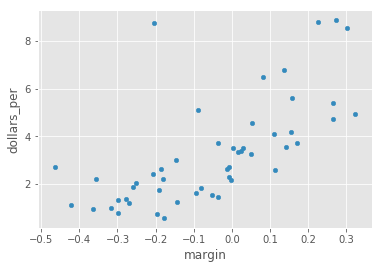

In [56]:
pres_votes['margin'] = (pres_votes['clinton']/pres_votes['total'])-(pres_votes['trump']/pres_votes['total'])

pres_votes_indexed = pres_votes.set_index('state')

votes_vs_contribs = actblue_contributor_states.merge(pres_votes_indexed, left_index=True, right_index=True, how='inner')

votes_vs_contribs['dollars_per'] = votes_vs_contribs['sum']/votes_vs_contribs['total']

votes_vs_contribs[votes_vs_contribs.index != "DC"].plot.scatter(x='margin', y='dollars_per')


In [57]:
votes_vs_contribs[votes_vs_contribs['dollars_per'] > 7.5]

,sum,percent,trump,clinton,others,total,red,blue,margin,dollars_per
CA,"120,996,840.61",21.40,4483814,8753792,943998,14181604,False,True,0.30,8.53
DC,"15,593,452.00",2.76,12723,282830,15715,311268,False,True,0.87,50.10
MA,"29,478,554.13",5.21,1090893,1995196,238957,3325046,False,True,0.27,8.87
MT,"4,350,052.33",0.77,279240,177709,40198,497147,True,False,-0.20,8.75
NY,"67,834,954.98",12.00,2819533,4556118,345791,7721442,False,True,0.22,8.79


In [58]:
votes_vs_contribs[votes_vs_contribs['dollars_per'] <= 1.3]

,sum,percent,trump,clinton,others,total,red,blue,margin,dollars_per
AR,"1,326,068.74",0.23,684872,380494,65310,1130676,True,False,-0.27,1.17
ID,"678,394.28",0.12,409055,189765,91435,690255,True,False,-0.32,0.98
LA,"1,492,898.96",0.26,1178638,780154,70240,2029032,True,False,-0.20,0.74
MS,"693,603.76",0.12,700714,485131,23512,1209357,True,False,-0.18,0.57
OK,"1,350,704.90",0.24,949136,420375,83481,1452992,True,False,-0.36,0.93
SC,"2,596,956.33",0.46,1155389,855373,92265,2103027,True,False,-0.14,1.23
SD,"284,378.60",0.05,227721,117458,24914,370093,True,False,-0.30,0.77
WV,"782,809.05",0.14,489371,188794,36258,714423,True,False,-0.42,1.10


In [59]:
votes_vs_contribs.groupby(votes_vs_contribs['blue'])['sum'].sum()

blue
False   184,571,241.06
True    379,108,414.88
Name: sum, dtype: float64

In [60]:
contrib_flow = pres_votes[['state','blue']].merge(pres_votes[['state','blue']].merge(actblue_states, right_on='contributor_state', left_on='state', how='inner'), right_on='recipient_state', left_on='state', how='inner', suffixes=['_recip','_contrib'])

contrib_flow

pd.pivot_table(contrib_flow, values='sum', index=['blue_recip'], columns=['blue_contrib'], aggfunc=np.sum)

blue_contrib,False,True
blue_recip,,
False,"154,078,338.58","155,785,480.14"
True,"30,491,504.45","223,302,983.37"


What does this mean? If you're an ActBlue donor from a blue state, you're most likely to give to candidates in a blue state (often your own). But a close second is a red state. If you're an ActBlue donor in a red state, you're more likely to give to a red state (mostly, but not entirely, your own), but a distant second is a blue state.

#### Removing in-state

In [61]:
pd.pivot_table(contrib_flow[~contrib_flow['in']], values='sum', index=['blue_recip'], columns=['blue_contrib'], aggfunc=np.sum)


blue_contrib,False,True
blue_recip,,
False,"42,266,001.24","155,785,480.14"
True,"30,491,504.45","95,513,102.10"


#### Recipient states not in state

In [62]:
actblue_recipient_out_states = actblue_states[~actblue_states['in']].groupby(actblue_states[~actblue_states['in']]['recipient_state']).agg({'sum': 'sum'})

actblue_recipient_out_states['percent'] = actblue_recipient_out_states['sum']/actblue_recipient_out_states['sum'].sum()*100

actblue_recipient_out_states.sort_values(by=['percent'], ascending=False)

,sum,percent
recipient_state,,
TX,"29,816,249.59",9.15
GA,"28,457,871.03",8.73
AL,"20,525,454.16",6.30
CA,"19,393,463.66",5.95
NY,"15,692,632.01",4.82
MA,"13,176,397.26",4.04
PA,"12,623,003.60",3.87
OH,"12,531,430.09",3.85
FL,"12,064,313.01",3.70


### What about 2014?

In [63]:
actblue_states_14 = read_or_save(
    'actblue_states_14',
    lambda: pd.read_sql("""
    SELECT contributor_state,
           coalesce(beneficiary_candidate_state,cand_office_st) as recipient_state,
           count(*),
           sum(contribution_amount)
    FROM actblue_contribs
    WHERE extract(YEAR FROM contribution_date) >= 2013
    and extract(YEAR FROM contribution_date) <= 2014
    and cand_office in ('H','S')
    GROUP BY coalesce(beneficiary_candidate_state,cand_office_st),
             contributor_state
    """, con=conn)
)

actblue_states_14.sort_values(by=['sum'], ascending=False).head(10)

,contributor_state,recipient_state,count,sum
252,CA,CA,133394,"7,012,698.42"
322,CO,CO,72560,"4,331,650.76"
2061,NY,NY,65793,"3,827,196.77"
2695,VA,VA,44953,"3,524,258.10"
817,IL,IL,52903,"3,371,706.41"
514,FL,FL,60414,"2,764,482.61"
1122,MA,MA,34224,"2,743,338.51"
1609,NC,NC,42142,"2,175,535.46"
185,AZ,AZ,48553,"2,156,247.86"
1302,MI,MI,31717,"1,799,950.21"


In [64]:
actblue_states_14['in'] = actblue_states_14['contributor_state'] == actblue_states_14['recipient_state']

contrib_flow_14 = pres_votes[['state','blue']].merge(pres_votes[['state','blue']].merge(actblue_states_14, right_on='contributor_state', left_on='state', how='inner'), right_on='recipient_state', left_on='state', how='inner', suffixes=['_recip','_contrib'])

pd.pivot_table(contrib_flow_14, values='sum', index=['blue_recip'], columns=['blue_contrib'], aggfunc=np.sum)

blue_contrib,False,True
blue_recip,,
False,"27,667,166.98","21,799,198.55"
True,"7,632,520.85","56,808,541.21"


#### Removing in-state

In [65]:
pd.pivot_table(contrib_flow_14[~contrib_flow_14['in']], values='sum', index=['blue_recip'], columns=['blue_contrib'], aggfunc=np.sum)


blue_contrib,False,True
blue_recip,,
False,"7,481,564.62","21,799,198.55"
True,"7,632,520.85","23,596,317.86"


## Percent of Clinton votes from California and New York

In [66]:
(pres_votes[pres_votes['state'] == 'CA']['clinton'].sum()+pres_votes[pres_votes['state'] == 'NY']['clinton'].sum())/pres_votes['clinton'].sum()

0.20211389175071204

### What about Texas? Which cities?

In [67]:
actblue_texas_cities = read_or_save(
    'actblue_texas_cities',
    lambda: pd.read_sql("""
    SELECT lower(contributor_city),
           count(*) AS COUNT,
           sum(contribution_amount) AS SUM
    FROM actblue_contribs
    WHERE contributor_state = 'TX'
      AND extract(YEAR
                  FROM contribution_date) > 2017
      AND beneficiary_candidate_office IN ('H','S')
    GROUP BY lower(contributor_city)
    ORDER BY COUNT DESC
    """, con=conn)
)

actblue_texas_cities['percent'] = actblue_texas_cities['sum']/actblue_texas_cities['sum'].sum()

actblue_texas_cities.head(5)

,lower,count,sum,percent
0,austin,136462,"6,658,372.44",0.20
1,houston,91804,"6,753,687.20",0.20
2,dallas,63994,"4,636,976.00",0.14
3,san antonio,43196,"1,688,745.49",0.05
4,fort worth,21636,"787,092.20",0.02


### What does this look like for special election candidates running in 2018?

In [68]:
specials = ['C00631564',
            'C00634543',
            'C00662650',
            'C00615823',
            'C00656116',
            'C00663161',
            'C00655332',
            'C00647339',
            'C00680348',
            'C00632067',
            'C00631945',
            'C00629659',
            'C00633362',
            'C00641340',
            'C00640623',
            'C00657411',
            'C00663914',
            'C00655977',
            'C00639401',
            'C00633610',
            'C00667964',
            'C00630426',
            'C00634709',
            'C00680942',
            'C00632232',
            'C00658708',
            'C00678672',
            'C00649897',
            'C00660142',
            'C00679779',
            'C00647917',
            'C00635128']

actblue_specials = actblue_proportion_amount[actblue_proportion_amount['cand_pcc'].isin(specials)].merge(actblue_transfers, left_on='cand_pcc', right_on='beneficiary_committee_fec_id', how='inner')[['cand_pcc','name','committee_total','actblue_total']]


In [69]:
actblue_specials.sum()

cand_pcc           C00615823C00629659C00630426C00631564C00632232C...
name               BARRERA FOR CONGRESSJIMMY GOMEZ FOR CONGRESSJO...
committee_total                                        82,121,621.48
actblue_total                                          72,978,917.38
dtype: object

### Do the majority of these donors give repeatedly or are they one and done? How “sticky” is this? What percentage of donors gave how many times?
Jan. 1, 2013 — now

_Note: Need to account for multi-candidate contribs._

In [70]:
actblue_freq = read_or_save(
    'actblue_freq',
    lambda: pd.read_sql("""
    SELECT COUNT,
           count(*) AS count_of_count
    FROM
      (SELECT contributor_first_name,
              contributor_last_name,
              left(contributor_zip_code,5),
              count(DISTINCT contribution_date::text || contribution_amount) AS COUNT
       FROM actblue_contribs
       WHERE extract(year from contribution_date) >= 2017
       GROUP BY contributor_first_name,
                contributor_last_name,
                left(contributor_zip_code,5)) AS donors
    GROUP BY COUNT
    """, con=conn)
)

actblue_freq['percent'] = actblue_freq['count_of_count']/actblue_freq['count_of_count'].sum()*100

actblue_freq.sort_values(by=['count_of_count'], ascending=False).head(5)

,count,count_of_count,percent
1007,1,1240596,34.74
102,2,738666,20.69
213,3,276326,7.74
632,4,225961,6.33
356,5,127387,3.57


In [71]:
actblue_freq.to_csv('data/actblue_freq.csv')

Spreadsheet: [actblue_freq.csv](data/actblue_freq.csv)

### ActBlue addicts: Do certain donors give a lot through ActBlue?
Jan. 1, 2017 — now

In [72]:
actblue_addicts = read_or_save(
    'actblue_addicts',
    lambda: pd.read_sql("""
    SELECT contributor_first_name,
           contributor_last_name,
           array_agg(DISTINCT contributor_occupation),
           array_agg(DISTINCT contributor_employer),
           array_agg(DISTINCT contributor_street_1),
           array_agg(DISTINCT contributor_city),
           contributor_state,
           left(contributor_zip_code,5) AS contributor_zip_code,
           count(*) AS COUNT,
           sum(contribution_amount) AS total,
           sum(contribution_amount)/count(*) AS avg_per
    FROM actblue_contribs
    WHERE extract(YEAR
                  FROM contribution_date) > 2016
    GROUP BY contributor_first_name,
             contributor_last_name,
             contributor_state,
             left(contributor_zip_code,5)
    ORDER BY COUNT DESC
    LIMIT 100
    """, con=conn)
)
actblue_addicts

,contributor_first_name,contributor_last_name,array_agg,array_agg,array_agg,array_agg,contributor_state,contributor_zip_code,count,total,avg_per
0,SIBYLLE,BARLOW,[RETIRED],[RETIRED],[241 HOLDEN WOOD ROAD],[CONCORD],MA,01742,17995,"67,973.95",3.78
1,JOHN,COMELLA,[NONE],[NONE],[1900 J F KENNEDY BLVD SUITE 1624],[PHILADELPHIA],PA,19103,11785,"35,048.60",2.97
2,TERRY,WOLFE,[RETAIL],"[LOWES, LOWE'S]","[1199 E 3RD ST, 1199 EAST THIRD STREET]",[MORGANTOWN],WV,26508,11349,"32,557.89",2.87
3,ROXANNE,WARREN,"[ARCHITECT, ARCHITECTS]",[SELF],[523 WEST 112TH STREET 72],[NEW YORK],NY,10025,9068,"96,462.68",10.64
4,CAROLINE,MERRIAM,[FOUNDATION PRESIDENT],[RAMSAY MERRIAM FUND],[1316 30TH STREET NW],[WASHINGTON],DC,20007,8651,"125,572.80",14.52
5,MARTHA,UTZ,[NOT EMPLOYED],[NOT EMPLOYED],[1118 ALLSTON CT],[SAN JOSE],CA,95120,8528,"29,855.01",3.50
6,VICKI,FARRAR,[NOT EMPLOYED],[NOT EMPLOYED],[P O BOX 140375],[GARDEN CITY],ID,83714,8432,"37,014.92",4.39
7,RICHARD,GOLDSTEIN,"[NOT EMPLOYED, RETIRED]","[NOT EMPLOYED, RETIRED]","[375 SAGAPONACK RD, L O BOX752, P O 752, POB0X...","[SAFAPONACK, SAGAPONACK]",NY,11962,8411,"146,650.73",17.44
8,MONIQUE,WEIL,[RETIRED],[NONE],[6022 MERRIEWOOD DR],[OAKLAND],CA,94611,8370,"55,854.87",6.67
9,GARLAND,RIGGS,"[NONE, NOT EMPLOYED]","[NONE, NOT EMPLOYED]",[8603 NIGHTINGALE DR ],[LANHAM],MD,20706,7865,"22,681.83",2.88


In [73]:
actblue_addicts.to_csv('data/actblue_addicts.csv')

Spreadsheet: [actblue_addicts.csv](data/actblue_addicts.csv)

### How did Terry Wolfe give?

In [74]:
actblue_wolfe = read_or_save(
    'actblue_wolfe',
    lambda: pd.read_sql("""
    SELECT contribution_date,
           contribution_amount,
           count(*),
           sum(contribution_amount)
    FROM actblue_contribs
    WHERE contributor_last_name = 'WOLFE'
      AND contributor_first_name = 'TERRY'
      AND cand_office IN ('S',
                          'H')
      AND extract(YEAR
                  FROM contribution_date) >= 2017
    GROUP BY contribution_date,
             contribution_amount
    ORDER BY count(*) DESC
    """, con=conn)
)
actblue_wolfe.head(5)

,contribution_date,contribution_amount,count,sum
0,2017-10-03,1.00,56,56.00
1,2017-09-28,1.00,55,55.00
2,2017-11-30,1.00,47,47.00
3,2018-03-31,1.00,46,46.00
4,2017-09-29,1.00,44,44.00


In [75]:
actblue_wolfe['sum'].describe()

count   1,330.00
mean       10.93
std        10.91
min         1.00
25%         4.00
50%         7.50
75%        14.83
max       115.00
Name: sum, dtype: float64

In [76]:
actblue_wolfe['sum'].sum()

14538.66

### Sibylle Barlow

In [77]:
actblue_barlow = read_or_save(
    'actblue_barlow',
    lambda: pd.read_sql("""
    SELECT contribution_date,
           contribution_amount,
           count(*),
           sum(contribution_amount)
    FROM actblue_contribs
    WHERE contributor_last_name = 'BARLOW'
      AND contributor_first_name = 'SIBYLLE'
      --AND cand_office IN ('S',
    --                      'H')
      AND extract(YEAR
                  FROM contribution_date) >= 2017
    GROUP BY contribution_date,
             contribution_amount
    ORDER BY count(*) DESC
    """, con=conn)
)
actblue_barlow['contribution_amount'].describe()

count   4,877.00
mean        6.26
std        56.45
min         0.10
25%         0.50
50%         2.50
75%         5.00
max     2,700.00
Name: contribution_amount, dtype: float64

### William Nottingham

In [78]:
actblue_nottingham = read_or_save(
    'actblue_nottingham',
    lambda: pd.read_sql("""
    SELECT *
    FROM actblue_contribs
    WHERE contributor_first_name = 'WILLIAM'
      AND contributor_last_name = 'NOTTINGHAM'
      AND contributor_state = 'CA'
      AND extract(YEAR
                  FROM contribution_date) >= 2017
    """, con=conn)
)
actblue_nottingham['contribution_amount'].sum()

7615.0

### What's the gender breakdown of ActBlue contribs?

In [79]:
actblue_first_names = read_or_save(
    'actblue_first_names',
    lambda: pd.read_sql("""
    SELECT contributor_first_name,
           count(*),
           sum(contribution_amount)
    FROM actblue_contribs
    WHERE extract(YEAR FROM contribution_date) >= 2017
    and cand_office in ('H','S')
    GROUP BY contributor_first_name
    """, con=conn)
)

d = gender.Detector(case_sensitive=False)

actblue_first_names['gender'] = actblue_first_names['contributor_first_name'].apply(d.get_gender)

actblue_first_names.sort_values(by=['count'], ascending=False).head(5)

,contributor_first_name,count,sum,gender
58357,JOHN,254614,"12,168,065.48",male
26247,DAVID,235000,"12,661,791.26",male
84952,MICHAEL,211878,"10,085,512.04",male
103479,ROBERT,208083,"9,860,271.09",male
116854,SUSAN,203196,"6,300,033.67",female


In [80]:
actblue_gender = actblue_first_names.groupby(actblue_first_names['gender'])['count','sum'].sum()

actblue_gender['percent_by_count'] = actblue_gender['count']/actblue_gender['count'].sum()*100
actblue_gender['percent_by_sum'] = actblue_gender['sum']/actblue_gender['sum'].sum()*100

actblue_gender

,count,sum,percent_by_count,percent_by_sum
gender,,,,
andy,98210,"3,366,518.99",0.64,0.60
female,7044569,"209,641,415.70",46.24,37.07
male,5672231,"266,176,456.87",37.24,47.07
mostly_female,737334,"22,488,407.01",4.84,3.98
mostly_male,349051,"13,983,833.77",2.29,2.47
unknown,1332133,"49,803,357.09",8.74,8.81


In [82]:
%%bash
jupyter nbconvert analysis.ipynb

[NbConvertApp] Converting notebook analysis.ipynb to html
[NbConvertApp] Writing 707839 bytes to analysis.html
